# Run2019 analysis

In this notebook, the efficiency is computed. Then, the measured neutrino spectrum at CONNIE is computed based on the neutrino spectrum from the reactor. Finally, this is compared to the differential rate measured from the run2019. The result achieved is of a 95% confidence level measured rate 16 times larger than the expected neutrino rate.


## Preamble

```bash
module load py-notebook/6.1.5-gcc-8.3.0-lim66g5
module load softwares/texlive/2017
pip3 install uproot –user
pip3 install uncertainties –user
```

In [1]:
%reload_ext autoreload
%autoreload 2

import sys, os
from glob import glob
from copy import *

from numpy import *
from scipy.optimize import curve_fit, least_squares
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic, norm, median_abs_deviation
from scipy.integrate import quad

import uproot
from uncertainties import *
from uncertainties import unumpy as un
from pint import UnitRegistry
from pint.numpy_func import HANDLED_FUNCTIONS
unit = UnitRegistry()
unit.define('event = []')

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
    "image.origin": 'lower',
    "font.family": "serif",
    "font.size": 12,
    "grid.alpha": .5,
})

def O(*funcs):
    def _f(arg):
        if len(funcs) == 1:
            return funcs[-1]( arg )
        return O( *funcs[:-1] )( funcs[-1]( arg ) )
    return _f


def C(*func):
    def _f(args):
        return [ func(args) for func in funcs ]
    return _f

def mapd( func, d, key=lambda _: _):
    return dict( map( lambda kv: ( key(kv[0]), func(kv[1]) ), d.items() ) )

mad = lambda x, axis=None: median_abs_deviation(x, axis=axis)

arange2 = lambda i,f,s: arange(i,f+s,s)
parange2 = lambda i,f,s: arange2(i.m, (f+s).m, s.m)*s.u
binCenters = lambda bins: (bins[1:]+bins[:-1])/2.
binErrs = lambda bins: (bins[1:] - bins[:-1])/2.

In [2]:
class Axes:
    def __init__(self, debug=False, xlabel='x', ylabel='y', title=None, 
                 xscale='linear', yscale='linear',
                 xlim=(None,None), ylim=(None,None), **kwargs):
        self.commands = []
        self.kwargs = kwargs
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.xscale = xscale
        self.yscale = yscale
        self.xlim = xlim
        self.ylim = ylim        
        self.title = title
        self.debug = debug
        self.commands.append( lambda ax: ax.set_xlabel(self.xlabel) )
        self.commands.append( lambda ax: ax.set_ylabel(self.ylabel) )
        self.commands.append( lambda ax: ax.grid(which='both') )
        if self.debug: print('init Axes')
    def __enter__(self, **kwargs):
        if self.debug: print('enter Axes')
        return self
    def __exit__(self, type, value, traceback):
        if type:
            print(type)
            print(value)
            print(traceback)
            raise type
        if self.debug: print('exiting Axes')
        self.commands.append( lambda ax: ax.legend(title=self.title) )
        self.commands.append( lambda ax: ax.set_xscale(self.xscale) )
        self.commands.append( lambda ax: ax.set_yscale(self.yscale) )
        self.commands.append( lambda ax: ax.set_xlim(*self.xlim) )
        self.commands.append( lambda ax: ax.set_ylim(*self.ylim) )
        return True
    def __getattr__(self, member):
        if self.debug: print( f'called {member}' )
        def command(*args, **kwargs):
            if self.debug: print( kwargs.keys(), self.kwargs.keys() )
            self.commands.append(
                lambda ax: getattr(ax, member)(
                    *args, **kwargs, **self.kwargs
                )
            )
            if self.debug: print( self.commands )
            return
        return command

class Figure:
    figsize = (16,4)
    number = 0
    def __init__(self, ncols=1, debug=False, **kwargs):
        self.axes = []
        self.ncols = ncols
        self.debug = debug
        if self.debug: print('init Figure')
    def __enter__(self):
        if self.debug: print('enter Figure')
        return self
    def __exit__(self, type, value, traceback):
        if type:
            print(type)
            print(value)
            print(traceback)
            raise type
            
        if self.debug: print( 'number of axes', len(self.axes) )
        nrows = int( len(self.axes)/self.ncols ) + 1
        if self.debug: print( 'nrows', nrows )
        fig = plt.figure(figsize=(
            Figure.figsize[0], 
            Figure.figsize[1]*nrows
        ))
        for i, axis in enumerate(self.axes):
            if self.debug: print('command', i)
            ax = fig.add_subplot(nrows, self.ncols, i+1)
            for command in axis.commands:
                if self.debug: print('command', command)
                command(ax)
        Figure.number += 1
        print(f'Figure [{Figure.number}]')
        plt.show()
        if self.debug: print('exiting Figure')
        return True
    def addAxes(self, **kwargs):
        ax = Axes(debug=self.debug, **kwargs)
        self.axes.append( ax )
        if self.debug: 
            print('number of axes', len(self.axes), kwargs.keys() )
        return ax

In [3]:
class BinnedSpectrum:
    def __init__(self, values, bins):
        self.values = values
        self.bins = bins
    
    def plot(self, ax, units, **kwargs):
        x = self.binCenters().to(units[0]).m
        y = un.nominal_values( self.values.to(units[1]).m )
        xerr = self.bins.to(units[0]).m[2]/2.
        yerr = un.std_devs( self.values.to(units[1]).m )
        ax.errorbar( 
            x, 
            y = y, 
            xerr = xerr, 
            yerr = self.s(), 
            fmt = ' ', 
            **kwargs 
        )

    def unit(self):
        return self.values.u
    
    def n(self):
        return un.nominal_values(self.values.m)
    
    def s(self):
        return un.std_devs(self.values.m)
    
    def binEdges(self):
        return arange2( *self.bins.m )*self.bins.u

    def binCenters(self):
        bins = self.binEdges()
        return .5*(bins[1:]+bins[:-1])
    
    def __truediv__(self, a):
        if hasattr(a, 'values'):
            _nom = a.values
        else: 
            _nom = a
        ret = 1*self.values
        ret[_nom > 0] /= _nom[_nom>0]
        return BinnedSpectrum( ret, self.bins )
    
    def __add__(self, a):
        print('add')
        return BinnedSpectrum( 
            array(self) + array(a), 
            self.bins
        )

    def __sub__(self, a):
        return BinnedSpectrum( 
            array(self) - array(a), 
            self.bins
        )

    def __mul__(self, a):
        return BinnedSpectrum( array(self) * array(a), self.bins)
        
    def fit_params(self, func, p0):
        popt, pcov = curve_fit( 
            func, 
            self.binCenters().m, 
            un.nominal_values(self.values.m), 
            sigma = un.std_devs(self.values.m),
            p0=p0
        )
        perr = sqrt(diag(pcov))
        return un.uarray( popt, perr )
    
    def fit_func(self, func, p0):
        return lambda x: func(x, *un.nominal_values(self.fit_params(func, p0) ))
    
    def plot_fit(self, ax, func, p0, **kwargs):
        x = self.binCenters()
        ax.plot( x.m, self.fit_func(func,p0)(x.m), **kwargs)
    
    def interp(self, **kwargs):
        return interp1d(self.binCenters(), self.n(), bounds_error=False, fill_value='extrapolate', **kwargs)
    
    @classmethod
    def fromCatalogs(cls, pattern, branch, bins, weights=None, 
                     cut=None, statistic='count', debug=False, _unit=None):
        values = uproot.concatenate(pattern, expressions=branch, cut=cut, library='np')[branch]
        values = ((values*unit(_unit)).to(bins.u)).m
        if debug: print( 'values', type(values), values.min(), values.max() )
        xbins = arange2(*bins.m)
        if debug: print( 'bins', xbins )
        w = ones_like(values)
        if weights:
            w = uproot.concatenate(pattern, expressions=weights, cut=cut, library='np')[weights]
        y = binned_statistic( values, w, bins=xbins, statistic=statistic )[0].astype(float)
        yerr = sqrt(y)
        return BinnedSpectrum( un.uarray(y, yerr)*unit.event, bins )
    
    @classmethod
    def fromFunc(cls, func, bins, epsrel=1e-4):
        x = arange2(*bins)
        y = array( [ quad( func, x[i], x[i+1], epsrel=epsrel )[0]/(x[i+1]-x[i]) 
                         for i in range(len(x)-1) ] )
        return BinnedSpectrum( un.uarray(y, 0), bins )

def printtable( *specs, xlabel='x', ylabels=['y'], fmt='uf' ):
    
    x = list(map(lambda s: f'{s}', specs[0].binEdges()[:-1]))
    xlen = max(map(len, x))

    y = [ list(map(lambda s: ('{:.1%s}'%fmt).format(s), spec)) for spec in specs ]
    ylen = [ max(map(len, _y)) for _y in y ]

    format_str = '{:<%s} | '%xlen
    format_str += ' | '.join( [ '{:<%s}'%_ylen for _ylen in ylen ] )
    
    print( format_str.format(xlabel, *ylabels) )
    print( '='*( xlen + sum(ylen) + 3*len(ylabels) ) )
    x = list(map(lambda s: ('{:>%s}'%(xlen)).format(s), x))
    y = [ list(map(lambda s: ('{:>%s}'%(_ylen)).format(s), _y)) for _y, _ylen in zip(y,ylen) ]

    table = list( zip(x, *y) )
    print( '\n'.join(map(lambda s: ' | '.join(s), table) ) )
    print( '='*( xlen + sum(ylen) + 3*len(ylabels) ) )

def nom( kernel, func, epsrel=1e-2, lims=(0, inf) ):
    return vectorize( lambda new_x: quad( 
        lambda x: kernel(new_x, x)*func(x), lims[0], lims[1], epsrel=epsrel 
    )[0] )

def den( kernel, epsrel=1e-2, lims=(0, inf) ):
    return vectorize( lambda new_x: quad( 
        lambda x: kernel(new_x, x), lims[0], lims[1], epsrel=epsrel 
    )[0] )

def convolveFuncs( kernel, func, epsrel=1e-2, lims=(0, inf) ):
    nomf = nom( kernel, func, epsrel=epsrel, lims=lims )
    denf = den( kernel, epsrel=epsrel, lims=lims)
    return lambda x: nomf(x)/denf(x)

In [4]:
pattern = {
    'match': '/share/storage2/connie/DAna/nuCatalogs/match_*_sim_[6-7]*_to_*_v4.0.root',
    'data': '/share/storage2/connie/DAna/nuCatalogs/shape_*_data_[6-7]*_to_*_v4.0.root',    
    'sim': '/share/storage2/connie/DAna/nuCatalogs/draw_all*.root',
}

# Efficiency

The first step in the analysis is to compute the reconstruction efficiency. In order to obtain it, neutrino-like events are simulated and added to the measured images. These events are randomly distributed in the active region of the CCD and uniformely in energy from 25 to 2500 eV. The images with the added events are then processed and the events are extracted as if they were real events. 

For the neutrino-like event simulations the ionization energies are given and then the measured energy of the same event is computed after the processing. Therefore, the efficiency $\epsilon$ is computed as the percentage of simulated events with given ionization energy $E_{\rm I}$ are detected in the final processed image,

$$
\epsilon(E_{\rm I}) = \frac{\cal{N}_{\rm R}}{\cal{N}},
$$
where the number of simulated events and the number of reconstructed events are, respectively, given by,
$$
{\cal N} = \frac{{\rm d} N}{{\rm d} E_{\rm I}}(E_{\rm I}),
\quad
{\cal N}_{\rm R} = \frac{{\rm d} N_{\rm R}}{{\rm d} E_{\rm I}}(E_{\rm I}).
$$


Below the matching condition to identify the events in the processed image with the simulation is defined by demanding the $x,y$ distance between the simulated and reconstructed events to be smaller then 1.5 pixels. Furthermore, the spectra are read from the `sim` and `match` catalogs for all images. The OHDU 3 is used here to exemplify the computation.

Figure [8]


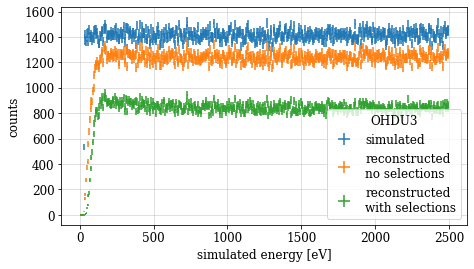

In [21]:
matchDistMax=1.5
selection = {}
selection['size'] = '(sizell<.95) & (sizell>0)'
selection['energy'] = '(E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50)'
selection['geom'] = '(xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)'

selection['sim'] = lambda ohdu: f'hdu=={ohdu}'
selection['match2'] = lambda ohdu: ' & '.join( [
    f'(ohdu=={ohdu}) & (distSim < {matchDistMax})', 
] )
selection['match'] = lambda ohdu: ' & '.join( [
    f'(ohdu=={ohdu}) & (distSim < {matchDistMax})', 
    selection['size'],
    selection['energy'],
    selection['geom']
] )

Ebins = (0, 2500, 5)*unit.eV

dN_dE = {}
ohdu = 3
dN_dE[ohdu] = {}
dN_dE[ohdu]['sim'] = BinnedSpectrum.fromCatalogs( f'{pattern["sim"]}:hitSumm', 'oEnergy',
    cut=selection['sim'](ohdu), bins=Ebins, _unit='eV' )
dN_dE[ohdu]['match'] = BinnedSpectrum.fromCatalogs( f'{pattern["match"]}:hitSumm', 'oEnergy',
    cut=selection['match'](ohdu), bins=Ebins, _unit='eV' )
dN_dE[ohdu]['match2'] = BinnedSpectrum.fromCatalogs( f'{pattern["match"]}:hitSumm', 'oEnergy',
    cut=selection['match2'](ohdu), bins=Ebins, _unit='eV' )

epsilon = {}
epsilon[ohdu] = dN_dE[ohdu]['match']/dN_dE[ohdu]['sim']
epsilon[f'{ohdu}_2'] = dN_dE[ohdu]['match2']/dN_dE[ohdu]['sim']

with Figure(ncols=2) as fig:
    with fig.addAxes(xlabel='simulated energy [eV]', ylabel='counts', 
                     title=f'OHDU{ohdu}') as ax:

        dN_dE[ohdu]['sim'].plot(ax, label='simulated', units=('eV','event'))
        dN_dE[ohdu]['match2'].plot(ax, label='reconstructed\nno selections', units=('eV','event'))
        dN_dE[ohdu]['match'].plot(ax, label='reconstructed\nwith selections', units=('eV','event'))


For comparison, the efficiency computed from the previously published 1x1 analysis is also defined using its parametrization. Two fitting functions are used in order to parametrize the novel 1x5 data.

In [26]:
def epsilon_old(E):
    E_ = E.to('keV')
    ret = zeros_like(E_)*unit('dimensionless')
    p = [17.14/unit.keV, 0.1239*unit.keV, 0.7426]
    Emin = 64*unit.eV
    ret[E_>Emin] = p[2] - exp(-p[0]*(E_[E_>Emin] - p[1]) )/( exp(-p[0]*(E_[E_>Emin] - p[1]) ) + 1 )
    return ret

tanhFit = lambda x, *p: p[2]*(( tanh( (x - p[1])/p[0] ) + 1 )/2)
expmFit = lambda x, *p: - 1/( 1 + exp(1./p[0]*(x - p[1]) ) ) + p[2]
params = epsilon[ohdu].fit_params(tanhFit, p0=[1.,1.,1.])
print( *map( lambda x: f'{x:.1uP}', params ) )

1.0±inf 1.0±inf 1.0±inf


/home/mota/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/home/mota/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Below, both the counts of simulated and reconstructed events are shown with their respective ionization energy. On the right plot, the ratio is computed togheter with the results of the fits and the comparison with the 1x1 efficiency.

/home/mota/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/home/mota/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/mota/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


Figure [11]


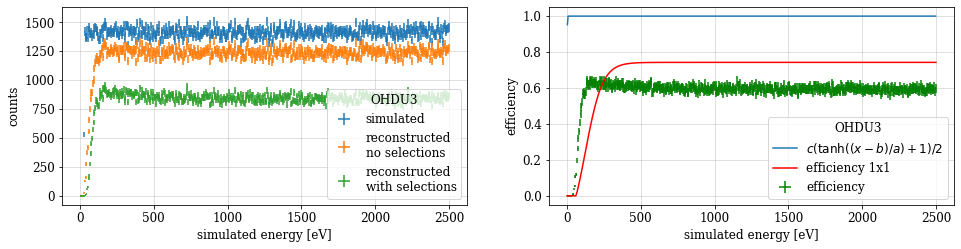

In [25]:
e = arange2(0, 2500, 10)*unit.eV
with Figure(ncols=2) as fig:
    with fig.addAxes(xlabel='simulated energy [eV]', ylabel='counts', 
                     title=f'OHDU{ohdu}') as ax:

        dN_dE[ohdu]['sim'].plot(ax, label='simulated', units=('eV','event'))
        dN_dE[ohdu]['match2'].plot(ax, label='reconstructed\nno selections', units=('eV','event'))
        dN_dE[ohdu]['match'].plot(ax, label='reconstructed\nwith selections', units=('eV','event'))
    
    with fig.addAxes(xlabel='simulated energy [eV]', ylabel='efficiency', title='OHDU3') as ax:
        epsilon[ohdu].plot( 
            ax, color='green',
            label='efficiency',
            units=('eV','event')
        )
        epsilon[ohdu].plot_fit(
            ax, tanhFit, p0=[1., 1., 1. ], 
            label=r'$c(\tanh((x - b)/a) + 1)/2$',
#             units=('eV','event')
        )
#         epsilon[ohdu].plot_fit(
#             ax, expmFit, p0=[10,10,10], 
#             label=r'$- 1/(1 + {\rm e}^{a*x-b})-c$' 
#         )
        ax.plot( e, epsilon_old(e), color='red', label='efficiency 1x1' )


In the 1x5 computation, the whole CCD active region was used. No selections were included. This represents the pure reconstruction efficiency. The fact that the 1x5 saturation value is higher than the 1x1 case might indicate that the last has included extra selections.

Below, the energy range of before the saturation is magnified for a detailed analysis.

/home/mota/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/home/mota/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/mota/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


[('a', '(1.0±inf)×10¹'), ('b', '(1.0±inf)×10¹'), ('c', '(1.0±inf)×10¹')]
Figure [10]


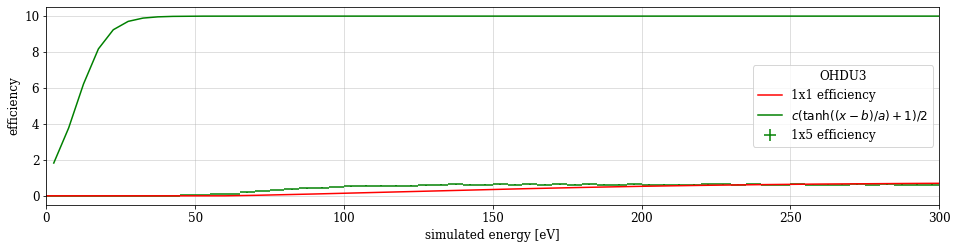

In [24]:
print( 
    list(
        zip(
            ['a','b','c'], 
            map( lambda x: f'{x:.1uP}', epsilon[3].fit_params(tanhFit, p0=[10,10,10]) )
        )
    ) 
)
with Figure() as fig:
    with fig.addAxes(
        title='OHDU3', xlabel='simulated energy [eV]', 
        ylabel='efficiency', xlim=(0,300)) as ax:
        
        ax.plot( e, epsilon_old(e), label='1x1 efficiency', color='red' )
        epsilon[ohdu].plot( ax, label='1x5 efficiency', color='green', units=('eV','event') )
        epsilon[ohdu].plot_fit(
            ax, tanhFit, p0=[10,10,10], color='green',
            label=r'$c(\tanh((x - b)/a) + 1)/2$' 
        )


The green line representing the hyperbolic tangent fit is preferred since it continuously goes to zero. The overvaluation below 25 eV is minimum and will not affect our final results.

Below, we compute the efficiency for all OHDU and compare their fits. There is a sizeable variation which implies that the analysis needs to be performed independently for each OHDU.

OHDU2
a: (1.0±inf)×10¹ b: (1.0±inf)×10¹ c: (1.0±inf)×10¹


/home/mota/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/home/mota/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


OHDU3
a: (1.0±inf)×10¹ b: (1.0±inf)×10¹ c: (1.0±inf)×10¹
OHDU4
a: (1.0±inf)×10¹ b: (1.0±inf)×10¹ c: (1.0±inf)×10¹
OHDU5
a: (1.0±inf)×10¹ b: (1.0±inf)×10¹ c: (1.0±inf)×10¹
OHDU8
a: (1.0±inf)×10¹ b: (1.0±inf)×10¹ c: (1.0±inf)×10¹
OHDU9
a: (1.0±inf)×10¹ b: (1.0±inf)×10¹ c: (1.0±inf)×10¹
OHDU13
a: (1.0±inf)×10¹ b: (1.0±inf)×10¹ c: (1.0±inf)×10¹
OHDU14
a: (1.0±inf)×10¹ b: (1.0±inf)×10¹ c: (1.0±inf)×10¹
Figure [4]


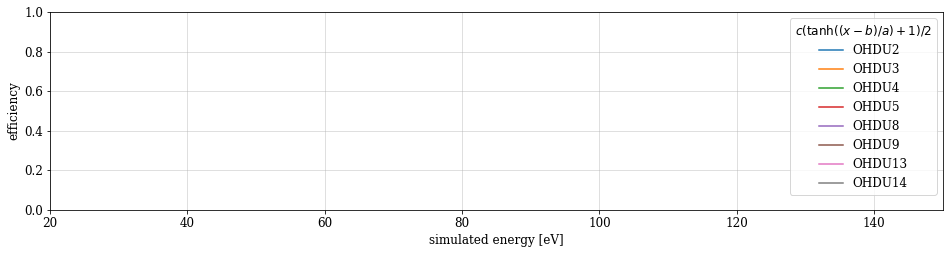

In [9]:
for ohdu in [2,3,4,5,8,9,13,14]:
    dN_dE[ohdu] = {}
    dN_dE[ohdu]['sim'] = BinnedSpectrum.fromCatalogs(
        f'{pattern["sim"]}:hitSumm', 
        'oEnergy',
        _unit='eV',
        cut=selection['sim'](ohdu), 
        bins=Ebins 
    )
    dN_dE[ohdu]['match'] = BinnedSpectrum.fromCatalogs( 
        f'{pattern["match"]}:hitSumm', 
        'oEnergy',
        _unit='eV',
        cut=selection['match'](ohdu), 
        bins=Ebins 
    )
    epsilon[ohdu] = dN_dE[ohdu]['match']/dN_dE[ohdu]['sim']
    print(f'OHDU{ohdu}')
    print(
        *map( lambda x: f'{x[0]}: {x[1]}', zip(
            ['a','b','c'], 
            map( lambda x: f'{x:.1uP}', epsilon[ohdu].fit_params(tanhFit, p0=[10,10,10]) )
        ) 
    ))

with Figure() as fig:
    with fig.addAxes(title=r'$c(\tanh((x - b)/a) + 1)/2$', 
                     xlabel='simulated energy [eV]', 
                     ylabel='efficiency', 
                     xlim=(20,150), ylim=(0,1)) as ax:
        for ohdu in [2,3,4,5,8,9,13,14]:
            epsilon[ohdu].plot_fit(
                ax, tanhFit, [10,10,10], label=f'OHDU{ohdu}'
            )

/home/mota/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/home/mota/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Figure [5]


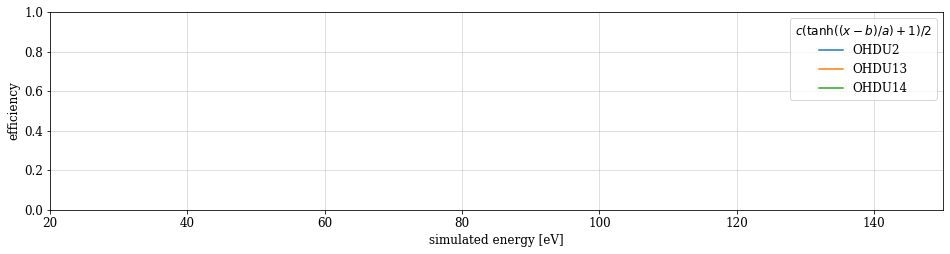

In [10]:
with Figure() as fig:
    with fig.addAxes(title=r'$c(\tanh((x - b)/a) + 1)/2$', 
                     xlabel='simulated energy [eV]', 
                     ylabel='efficiency', 
                     xlim=(20,150), ylim=(0,1)) as ax:
        for ohdu in [2,13,14]:
            (dN_dE[ohdu]['match']/dN_dE[ohdu]['sim']).plot_fit(
                ax, tanhFit, [10,10,10], label=f'OHDU{ohdu}'
            )

# Quenching factor
Below we define [Brenda's](https://arxiv.org/pdf/1910.04951) parametrization of Chavarria's the quenching factor
$$
Q(E_{\rm I}) = \frac{ p_3 E_{\rm I} + p_4 E_{\rm I}^2 + E_{\rm I}^3 }{ p_0 + p_1 E_{\rm I} + p_2 E_{\rm I}^2}
$$
where $p = \{50{\rm keV}^3, 1096{\rm keV}^2, 382{\rm keV}, 168{\rm keV}^2, 155{\rm keV}\}$. This is not used for now in the following calculation, since the neutrino spectrum I have is already multiplied by Juan for by the quenching factor used in DAMIC.

In [11]:
Q = {}
dQ_dE = {}
def Chavarria(E, diff=False):
    p = [ 56, 1096, 382, 168, 155 ]
    E = E/1e3
    num = p[3]*E + p[4]*E**2 + E**3
    den = p[0] + p[1]*E + p[2]*E**2
    if diff:
        dnum = (p[3] + 2*p[4]*E + 3*E**2)/1e3
        dden = (p[1] + 2*p[2]*E)/1e3
        return dnum/den - num/den**2*dden
    return num/den

def constant(E, diff=False):
    k = .305
    if diff:
        return zeros_like(E)
    return k*ones_like(E)

Q['Chavarria'] = Chavarria
dQ_dE['Chavarria'] = lambda E: Chavarria(E, diff=True)
Q['constant'] = constant
dQ_dE['constant'] = lambda E: constant(E, diff=True)


Figure [6]


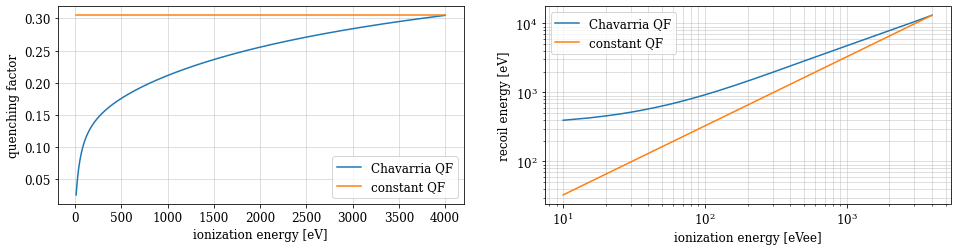

In [12]:
_E = arange2(10,4000,5)
with Figure(ncols=2) as fig:
    with fig.addAxes(xlabel='ionization energy [eV]', ylabel='quenching factor') as ax:
        ax.plot( _E, Q['Chavarria'](_E), label='Chavarria QF' )
        ax.plot( _E, Q['constant'](_E), label='constant QF' )
    with fig.addAxes(xscale='log', yscale='log', xlabel='ionization energy [eVee]', 
                     ylabel='recoil energy [eV]') as ax:
        ax.plot( _E, _E/Q['Chavarria'](_E), label='Chavarria QF' )
        ax.plot( _E, _E/Q['constant'](_E), label='constant QF' )

Once the recoil neutrino rate is known, it needs to be converted into ionization energy rate. This is achieved by using the quenching factor $Q = E_{\rm I}/E_{\rm R}$. So the ionization neutrino rate can be computed as,
$$
\frac{{\rm d} R}{{\rm d} E_{\rm I} } 
= \frac{{\rm d} R}{{\rm d} E_{\rm R} } \frac{{\rm d} E_{\rm R}}{{\rm d} E_{\rm I} }
= \frac{{\rm d} R}{{\rm d} E_{\rm R} } \frac{1}{Q(E_{\rm I})}\left( 
    1 - \frac{E_{\rm I}}{Q(E_{\rm I})} \frac{{\rm d} Q}{{\rm d} E_{\rm I} } 
\right).
$$

# Ionization neutrino rate
Using the ionization neutrino rate provided by Juan computed with the DAMIC's quenching factor. The table is provided in the 'vSpectrum.csv' file and for the purpose of this notebook, the energy unit is converted from keV to eV. The range of energy is chosen to be from 30 to 500 eV which is restrained by the given table.

In [13]:
# def dsigmaSM_dER(ER, Enu):
#     Q['W'] = N - (1 - 4*sin(thetaw)**2)*Z
#     return G['F']**2/(2*pi)*Q['W']**2 * (
#         1 - .5*M*ER/Enu**2 - ER/Enu + .5*ER**2/Enu**2
#     )*M*F(q)

In [14]:
%%bash
tail vSpectrum.csv

0.51	1.8994459407995314
0.52	1.771334548592241
0.53	1.6527744953208767
0.54	1.542967106244242
0.55	1.4412010621991433
0.56	1.3468180750171053
0.5700000000000001	1.2592299018797006
0.5800000000000001	1.17789141822265
0.59	1.1023140063491703
0.6	1.0320442835178236

In [15]:
def load_nuSpectrum(file, _unit, **kwargs):
    data = genfromtxt(file, **kwargs)
    nuSpectrum = interp1d( 
        *data.T,
        kind='slinear',
        bounds_error=False, 
        fill_value='extrapolate' 
     )
    return lambda x: nuSpectrum(x.to(_unit))

dR_dE = {}

E = arange2(30., 500, 1)*unit.eV

dR_dE['Juan'] = {}
dR_dE['Juan']['I'] = lambda x: load_nuSpectrum(file='vSpectrum.csv', _unit='keV' )(x)

/home/mota/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/home/mota/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/home/mota/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


Figure [7]


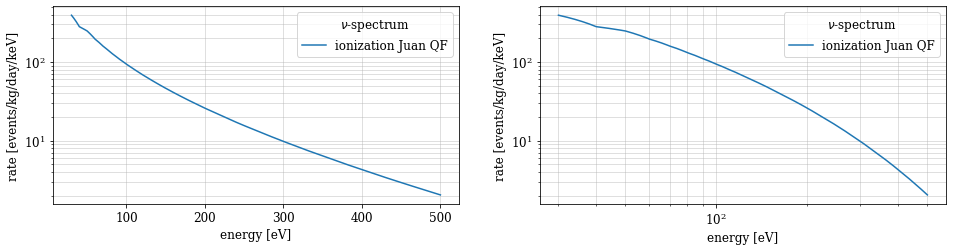

In [16]:
with Figure(ncols=2) as fig:
    for xscale in ['linear', 'log']:
        with fig.addAxes(xlabel='energy [eV]', ylabel='rate [events/kg/day/keV]', 
                         xscale=xscale, yscale='log', title=r'$\nu$-spectrum') as ax:
            ax.plot(E, dR_dE['Juan']['I'](E), label=r"ionization Juan QF")


The ionization neutrino rate can then be corrected by the efficiency of reconstruction for each of the ionization energies computed above from the simulations for OHDU3 as,
$$
\frac{{\rm d} R'}{{\rm d} E_{\rm I} } = \epsilon(E_{\rm I}) \frac{{\rm d} R}{{\rm d} E_{\rm I} }.
$$

In [17]:
dR_dE['1x5'] = {}
dR_dE['1x1'] = {}
dR_dE['1x5']['I*'] = lambda E, ohdu=3: epsilon[ohdu].fit_func(tanhFit, p0=[10,10,10])(E)*dR_dE['Juan']['I'](E)
dR_dE['1x1']['I*'] = lambda E: epsilon_old(E)*dR_dE['Juan']['I'](E)

E = arange(30, 500, 1)
with Figure(ncols=2) as fig:
    with fig.addAxes(xlabel='ionization energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                     title='efficiency', ylim=(0,100)) as ax:
        ax.plot( E, dR_dE['Juan']['I'](E), label=r'Juan')
        ax.plot( E, dR_dE['1x5']['I*'](E,2), label='1x5 OHDU2')
        ax.plot( E, dR_dE['1x5']['I*'](E,13), label='1x5 OHDU13')
        ax.plot( E, dR_dE['1x1']['I*'](E), label=r'1x1 efficiency')
    
    with fig.addAxes(xlabel='ionization energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                     title='efficiency',
                    xscale='log', yscale='log', ylim=(None,1e3)) as ax:
        ax.plot( E, dR_dE['Juan']['I'](E), label=r'Juan')
        ax.plot( E, dR_dE['1x5']['I*'](E,2), label='1x5 OHDU2')
        ax.plot( E, dR_dE['1x5']['I*'](E,13), label='1x5 OHDU13')
        ax.plot( E, dR_dE['1x1']['I*'](E), label=r'1x1 efficiency')

<class 'AttributeError'>
'numpy.ndarray' object has no attribute 'to'
<class 'AttributeError'>



AttributeError: 

The quenched rate is shown in blue. In orange, the calculation using the 1x5 efficiency and in green, for comparion, the 1x1 efficiency is applied as dicussed before.

In order to express the ionization neutrino rate in terms of the measured energy, the above spectrum needs to be convoluted with the distribution between the measured energy determination in respect to the ionization energy (from the simulations). Therefore, the distributions are computed by for each reconstructed energy bin. From them, the standard deviation is extracted as a function of the measured energy. It is interpreted as the range of ionization energies that contribute for each measured energy. A normal distribution is assumed and convoluted with the ionization neutrino rate to provide the final measured neutrino rate as follows,
$$
\frac{{\rm d} R'(E_{\rm M})}{{\rm d} E_{\rm M} } = 
\frac{1}{W(E_{\rm M})}
\int_0^\infty {\rm d}E_{\rm I}\,G \left( E_{\rm I} - E_{\rm M}; \sigma(E_{\rm M}) \right) \frac{{\rm d} R'(E_{\rm I})}{{\rm d} E_{\rm I} },
$$
where the normalization is,
$$
W(E_{\rm M}) = \int_0^\infty {\rm d}E_{\rm I}\,G \left( E_{\rm I} - E_{\rm M}; \sigma(E_{\rm M}) \right).
$$

Below, the standard deviations of the ionization energy distributions for each measured energy bin are shown.

In [ ]:
sigma = {}
sigma['M'] = {}
sigma['M'][3] = BinnedSpectrum.fromCatalogs(f'{pattern["match"]}:hitSumm', 'E1/gain3Peaks*1e3', (20, 500, 10), 
                         weights='oEnergy', cut='(ohdu==3) & (distSim<1.5)', statistic='std' )
sigma['M'][2] = BinnedSpectrum.fromCatalogs(f'{pattern["match"]}:hitSumm', 'E1/gain3Peaks*1e3', (20, 500, 10), 
                         weights='oEnergy', cut='(ohdu==2) & (distSim<1.5)', statistic='std' )
sigma['M'][13] = BinnedSpectrum.fromCatalogs(f'{pattern["match"]}:hitSumm', 'E1/gain3Peaks*1e3', (20, 500, 10), 
                         weights='oEnergy', cut='(ohdu==13) & (distSim<1.5)', statistic='std' )

with Figure() as fig:
    with fig.addAxes(ylabel='ionization energy [eVee]', xlabel='measured energy [eVee]',
                    title='measured energy dispersion') as ax:
        sigma['M'][2].plot(ax, label=r'$\sigma(E_{\rm M})$ OHDU2')
#         sigma['M'][3].plot(ax, label=r'$\sigma(E_{\rm M})$ OHDU3')
        sigma['M'][13].plot(ax, label=r'$\sigma(E_{\rm M})$ OHDU13')

Then, the normal kernels are convoluted with the rates for the 1x5 case as well as for the 1x1 case for comparison. A binsize of 10 eV is used to sample the convolution and generate a interpolation in order to alleviate the computational cost of recalculating this quantity for arbitrary measured energy values.

In [ ]:
kernel = {}
kernel[2] = lambda E_new, E: norm.pdf(E_new, loc=E, scale=sigma['M'][2].interp()(E_new) )
kernel[13] = lambda E_new, E: norm.pdf(E_new, loc=E, scale=sigma['M'][13].interp()(E_new) )
E = arange(30, 500, 10)

dR_dE['1x5']['M'] = {}
dR_dE['1x5']['M'][2] = interp1d( 
    E, 
    convolveFuncs(kernel[2], 
                  lambda E: dR_dE['1x5']['I*'](E,2), lims=(30,500)
                 )(E)
)
dR_dE['1x5']['M'][13] = interp1d( 
    E, 
    convolveFuncs(kernel[13], 
                  lambda E: dR_dE['1x5']['I*'](E,13), lims=(30,500)
                 )(E)
)


Below, measured rate is compared with the efficiency corrected and the quenched rates. Both 1x5 and 1x1 are shown for comparison. It is clear that the 1x5 efficiency allows for the exploration of much lower measure energies and captures a much larger rate if compared to the 1x1 case. The increase is of a factor 4. This is a very strong advantage in using the 1x5 binning. Even though, this binning masks the geometric features of the events.

In [ ]:
with Figure(ncols=1) as fig:
    for yscale in ['linear', 'log']:
        with fig.addAxes(xlabel='measured energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                         title='measured energy',
                         ylim=(0,100), yscale=yscale) as ax:
            ax.plot( E, dR_dE['Juan']['I'](E), color='gray', label=r'Juan')
            ax.plot( E, dR_dE['1x1']['I*'](E), 'g-.') #, label=r'1x1 ionization')
            ax.plot( E, dR_dE['1x1']['M'](E), 'g-', lw=3, label=r'1x1')
            ax.plot( E, dR_dE['1x5']['I*'](E,2), '-.', color='orange' ) #, label=r'1x5 OHDU2 ionization')
            ax.plot( E, dR_dE['1x5']['M'][2](E), '-', lw=3, color='orange', label=r'1x5 OHDU2')
            ax.plot( E, dR_dE['1x5']['I*'](E,13), '-.', color='blue') #, label=r'1x5 OHDU13 ionization')
            ax.plot( E, dR_dE['1x5']['M'][13](E), '-', lw=3, color='blue', label=r'1x5 OHDU13')


Below, the expected rates are binned in order to compare with the ON–OFF differential measured rates. Three binsizes are shown. The same value as the previous paper, 200 eV, to compare the expected rate obtained by this calculation and the paper's result. The value to be used in the current paper, 130 eV. And, 50 eV, for future use.

In [ ]:
for Emin, binsize in [(75, 200), (50,130)]:
    bins = (Emin, 430, binsize)
    with Figure(ncols=2) as fig:
        for yscale in ['linear', 'log']:
            with fig.addAxes(xlabel='measured energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                             title=f'$\Delta E={binsize}$eV', yscale=yscale, ylim=(1,80)) as ax:
                ax.plot( E, dR_dE['Juan']['I'](E), color='grey', label=r'Juan')
                ax.plot( E, dR_dE['1x5']['M'][2](E), color='orange') #, label=r'1x5 OHDU2 measured')
                r2 = BinnedSpectrum.fromFunc(dR_dE['1x5']['M'][2], bins )
                r2.plot(ax, color='orange', lw=3, label=f'1x5 OHDU2')
                
                ax.plot( E, dR_dE['1x5']['M'][13](E), color='blue')#, label=r'1x5 OHDU3')
                r13 = BinnedSpectrum.fromFunc(dR_dE['1x5']['M'][13], bins )
                r13.plot(ax, color='blue', lw=3, label=f'1x5 OHDU13')
                
            with fig.addAxes(xlabel='measured energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                             title=f'$\Delta E={binsize}$eV', yscale=yscale, ylim=(1,80)) as ax:
                ax.plot( E, dR_dE['Juan']['I'](E), color='gray', label=r'Juan')
                ax.plot( E, dR_dE['1x1']['M'](E), color='green', label=r'1x1 measured')
                r1 = BinnedSpectrum.fromFunc(dR_dE['1x1']['M'], bins )
                r1.plot(ax, color='green', label=f'1x1 $\Delta E={binsize}$eV')
                
        printtable(r2, r13, r1, xlabel='E', ylabels=['1x5(2)', '1x5(13)', '1x1'], fmt='f')


The values obtained in the 200 eV binsize table are compatible with the values in the paper. The gain in expected neutrinos using the 1x5 binning is of 6 times, compared to the previous 1x1 efficiency corrected neutrino rate for the first bin of 130 eV. And reaches 10 times for the 50 eV case.

# ON–OFF 2019

In this section, the reactor ON and OFF data are selected using the agreed runID, geometric, energy and event-size selection cuts. These are defined below.

In [ ]:
runIDexcluded = [6415, 6475, 6499, 6926, 6927, 6031, 6093, 6096, 6139, 7074, 7222, 7226, 7374]
selection = {}
selection['runID'] = ' & '.join(map(lambda s: f'(runID!={s})', runIDexcluded))

selection['size'] = '(sizell<.95) & (sizell>0)'
selection['energy'] = '(E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50)'
selection['geom'] = '(xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)'
selection['ohdu'] = '(' + ' | '.join(map(lambda s: f'(ohdu=={s})', [2,3,4,5,8,9,13,14])) + ')'

selection['runIDon'] = '( ((runID>6030) & (runID<6227)) | ((runID>6974) & (runID<7522)) )'
selection['runIDoff'] = '(runID>6226) & (runID<6975)'

selection['on'] = lambda ohdu: ' & '.join( [
    selection['runID'], 
    selection['size'], 
    selection['energy'], 
    selection['geom'],
    selection['ohdu'],
    selection['runIDon'],
    f'(ohdu=={ohdu})'
] )
selection['off'] = lambda ohdu: ' & '.join( [
    selection['runID'], 
    selection['size'], 
    selection['energy'], 
    selection['geom'],
    selection['ohdu'],
    selection['runIDoff'],
    f'(ohdu=={ohdu})'
] )

The energy distributions for the OHDU 3 is computed for illustration of the calculation. 

In [ ]:
dN_dE['on'] = {}i
dN_dE['off'] = {}
Ebins = (50, 9000, 130)
dN_dE['on'][3] = BinnedSpectrum.fromCatalogs(
    f'{pattern["data"]}:hitSumm', 'E1/gain3Peaks', cut=selection['on'](3), bins=Ebins, _unit='keV'
)
dN_dE['off'][3] = BinnedSpectrum.fromCatalogs(
    f'{pattern["data"]}:hitSumm', 'E1/gain3Peaks', cut=selection['off'](3), bins=Ebins, _unit='keV'
)

nImages = {}
nImages['on'] = unique(uproot.concatenate(
    f'{pattern["data"]}:hitSumm', 'runID', library='np', cut=selection['on'](3)
)['runID'])
nImages['off'] = unique(uproot.concatenate(
    f'{pattern["data"]}:hitSumm', 'runID', library='np', cut=selection['off'](3)
)['runID'])

From the events counts, the rates are compared using the total mass and time exposure fo the CCDs.

In [ ]:
dR_dE['on'] = {}
dR_dE['off'] = {}
dR_dE['on2'] = {}
dR_dE['off2'] = {}
rho = 2.42*1e-3*(1e2)**3 #kg/m^3
dM = rho * (15*1e-6)**2 * 675*1e-6 * 4120**2
dM2 = rho * (15*1e-6)**2 * 675*1e-6 * (3960-140)*(898-75)
dT = {}
dT['on'] = len(nImages['on'])/24
dT['off'] = len(nImages['off'])/24

dR_dE['on'][3] = dN_dE['on'][3]/dT['on']/dM/(1e-3*Ebins[-1])
dR_dE['off'][3] = dN_dE['off'][3]/dT['off']/dM/(1e-3*Ebins[-1])
dR_dE['on2'][3] = dN_dE['on'][3]/dT['on']/dM2/(1e-3*Ebins[-1])
dR_dE['off2'][3] = dN_dE['off'][3]/dT['off']/dM2/(1e-3*Ebins[-1])

Below, the uncorrected counts are shown in the left. In the right, the rates of both reactor ON and OFF are presented. In the bottom, the differential rate. All for the OHDU 3.

In [ ]:
with Figure(ncols=2) as fig:
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='counts',
        title='OHDU3'
    ) as ax:
        dN_dE['on'][3].plot(ax, label='ON')
        dN_dE['off'][3].plot(ax, label='OFF')
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title='OHDU3'
    ) as ax:
        dR_dE['on'][3].plot(ax, label='ON')
        dR_dE['off'][3].plot(ax, label='OFF')
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title='OHDU3'
    ) as ax:
        diff = dR_dE['on'][3] - dR_dE['off'][3]
        diff.plot(ax, label=r'ON–OFF')


At this point, all the OHDU rates are generated and shown below.

In [ ]:
for ohdu in [2,3,4,5,8,9,13,14]:
    dN_dE['on'][ohdu] = BinnedSpectrum.fromCatalogs(
        f'{pattern["data"]}:hitSumm', 
        'E1/gain3Peaks*1e3', 
        cut=selection['on'](ohdu), 
        bins=Ebins
    )
    dN_dE['off'][ohdu] = BinnedSpectrum.fromCatalogs(
        f'{pattern["data"]}:hitSumm', 
        'E1/gain3Peaks*1e3', 
        cut=selection['off'](ohdu), 
        bins=Ebins
    )
    
    dR_dE['on'][ohdu] = dN_dE['on'][ohdu]/dT['on']/dM/(1e-3*Ebins[-1])
    dR_dE['off'][ohdu] = dN_dE['off'][ohdu]/dT['off']/dM/(1e-3*Ebins[-1])
    dR_dE['on2'][ohdu] = dN_dE['on'][ohdu]/dT['on']/dM2/(1e-3*Ebins[-1])
    dR_dE['off2'][ohdu] = dN_dE['off'][ohdu]/dT['off']/dM2/(1e-3*Ebins[-1])

In [ ]:
with Figure(ncols=2) as fig:
    for ohdu in [2,3,4,5,8,9,13,14]:
        with fig.addAxes(
            xlabel='measured energy [eVee]', 
            ylabel='rate [events/kg/day/keV]',
            title=f'OHDU{ohdu}'
        ) as ax:
            diff = dR_dE['on'][ohdu] - dR_dE['off'][ohdu]
            diff.plot(ax, label=r'ON–OFF')


The combined differential rate is obtained by taking the weighted average of all the OHDUs. For comparison, the mean is also computed.

In [ ]:
def bmean( args, axis=None ):
    bins = args[0].bins
    m = mean( list(map(array, args)), axis=axis )
    return BinnedSpectrum(m, bins)

def baverage( args, axis=None ):
    bins = args[0].bins
    stds = array(list(map(lambda x: array(x.s()), args)))
    values = array(list(map(array, args)))
    ave = sum( values/stds**2, axis=axis)/sum(1./stds**2, axis=axis)
    return BinnedSpectrum(ave, bins)

meanDiff = bmean( 
    [ dR_dE['on'][ohdu] - dR_dE['off'][ohdu] for ohdu in [2,3,4,5,8,9,13,14] ], 
    axis=0
)
aveDiff = baverage(
    [ dR_dE['on'][ohdu] - dR_dE['off'][ohdu] for ohdu in [2,3,4,5,8,9,13,14] ], 
    axis=0
)
aveDiff2 = baverage(
    [ dR_dE['on2'][ohdu] - dR_dE['off2'][ohdu] for ohdu in [2,3,4,5,8,9,13,14] ], 
    axis=0
)
aveOn = baverage(
    [ dR_dE['on'][ohdu] for ohdu in [2,3,4,5,8,9,13,14] ], 
    axis=0
)

aveOff = baverage(
    [ dR_dE['off'][ohdu] for ohdu in [2,3,4,5,8,9,13,14] ], 
    axis=0
)


new_bins = list(meanDiff.bins)
new_bins[1] = 400
binnedRate2 = BinnedSpectrum.fromFunc(dR_dE['1x5']['M'][2], new_bins )
binnedRate13 = BinnedSpectrum.fromFunc(dR_dE['1x5']['M'][13], new_bins )


Below, the combined differential rate is compared with the expected neutrino rate obtained in the previous section. At the bottom, the 95% confidence level rate is shown also.

In [ ]:
oneSidedCL = 1.64
aveDiff95CF = BinnedSpectrum( array(aveDiff.n()) + oneSidedCL*array(aveDiff.s()), aveDiff.bins )
aveDiff295CF = BinnedSpectrum( array(aveDiff2.n()) + oneSidedCL*array(aveDiff2.s()), aveDiff.bins )

with Figure(ncols=1) as fig:
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title=f'combined'
    ) as ax:
        aveOn.plot(ax, label=r'reactor ON')
        aveOff.plot(ax, label=r'reactor OFF')
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title=f'combined'
    ) as ax:
        aveDiff.plot(ax, label=r'ON–OFF weighted')
        binnedRate2.plot(ax, label='OHDU2 expected')
        binnedRate13.plot(ax, label='OHDU13 expected')
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title=f'combined 95% CL',
        yscale='log'
    ) as ax:
        aveDiff95CF.plot(ax, label=r'ON–OFF weighted')
        binnedRate2.plot(ax, label='OHDU2 expected')
        binnedRate13.plot(ax, label='OHDU13 expected')
        

In blue, the mean differential rates. In orange, the weighted averages and in green the expected rates.

Below, the table with the values are presented for the energy range of interest. Also, the ratio between the 95% confidence level of the measurement and the expected rate. The 95% CF level measument is 16 times larger than the expected rate. This is a significant increase in comparison with the 40 times result achieved in the previous paper.

In [ ]:
aveDiff95CF3 = BinnedSpectrum( aveDiff95CF[:3], binnedRate.bins )
binnedRate2_ = BinnedSpectrum( array(binnedRate2.n()), binnedRate.bins )
binnedRate13_ = BinnedSpectrum( array(binnedRate13.n()), binnedRate.bins )

printtable( 
    aveDiff95CF3, 
    binnedRate2_, 
    aveDiff95CF3/binnedRate2_, 
    binnedRate13_, 
    aveDiff95CF3/binnedRate13_, 
    xlabel='E', 
    ylabels=['95%CL', 'R2', 'x', 'R13', 'x'], 
    fmt='f' 
)

with Figure(ncols=2) as fig:
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title=f'combined 95%CL',
        yscale='log'
    ) as ax:
        aveDiff95CF3.plot(ax, label=r'ON–OFF')
        binnedRate2_.plot(ax, label='expected OHDU2')
        binnedRate13_.plot(ax, label='expected OHDU13')


In [ ]:
Ebins = (50, 450, 50)
for ohdu in [2,3,4,5,8,9,13,14]:
    dN_dE['on'][ohdu] = BinnedSpectrum.fromCatalogs(
        f'{pattern["data"]}:hitSumm', 
        'E1/gain3Peaks*1e3', 
        cut=selection['on'](ohdu), 
        bins=Ebins
    )
    dN_dE['off'][ohdu] = BinnedSpectrum.fromCatalogs(
        f'{pattern["data"]}:hitSumm', 
        'E1/gain3Peaks*1e3', 
        cut=selection['off'](ohdu), 
        bins=Ebins
    )
    
    dR_dE['on'][ohdu] = dN_dE['on'][ohdu]/dT['on']/dM/(1e-3*Ebins[-1])
    dR_dE['off'][ohdu] = dN_dE['off'][ohdu]/dT['off']/dM/(1e-3*Ebins[-1])

aveDiff = baverage(
    [ dR_dE['on'][ohdu] - dR_dE['off'][ohdu] for ohdu in [2,3,4,5,8,9,13,14] ], 
    axis=0
)

aveDiff95CF = BinnedSpectrum( array(aveDiff.n()) + 2*array(aveDiff.s()), Ebins )
expectedRate = BinnedSpectrum.fromFunc( dR_dE['1x5']['M'], Ebins )
expectedRate = BinnedSpectrum( array(expectedRate.n()), Ebins )

printtable( 
    aveDiff95CF, 
    expectedRate, 
    aveDiff95CF/expectedRate, 
    xlabel='E', 
    ylabels=['95%CL', 'rate', 'ratio'], 
    fmt='f' 
)

with Figure(ncols=1) as fig:
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title=f'combined 95%CL',
        yscale='log'
    ) as ax:
        aveDiff95CF.plot(ax, label=r'ON–OFF')
        expectedRate.plot(ax, label='expected rate')


In [ ]:
# previous paper
Ebins = (75, 200, 700)
diffRate = {}
diffRate['1x1'] = [198.3376620671329, 110.13266987335254, 46.41588833612772]
diffRate['Lindhard'] = [11.478370518043963, 3.5391762881991546, 0.8282542492576113]
diffRate['Chavarria'] = [4.83760872099896, 1.264143590947761, 0.29045165289764596]


In [ ]:
%%bash
tail vFlux.csv

In [ ]:
%%bash
tail vSpectrum.csv

In [ ]:
#neutrino flux @CONNIE
E_flux = arange2(0, 4, .05)
vFlux = load_nuSpectrum(E_flux, file='vFlux.csv', delimiter=', ')
with Figure(ncols=2) as fig:
    with fig.addAxes(
        yscale='log', 
        xlabel='neutrino energy [MeV]', 
        ylabel=r'neutrino flux [events/MeV/cm$^2$/s]') as ax:
        
        ax.plot(E_flux, vFlux(E_flux), label=r'$\nu$ flux')

In [ ]:
class Unit(ndarray):
    def __new__(cls, array, unit):
        obj = asarray(array).view(cls)
        obj.unit = unit
        return obj
        
    def __finalize_array__(self, obj):
        if obj is None: return
        self.unit = obj.unit
        
    @classmethod
    def addUnit(cls, unit):
        setattr(cls, unit, )


In [ ]:
from pint import UnitRegistry

In [ ]:
Ebins = (30,600,100)*unit.eV
print( parange2(*Ebins) )
ureg.define('event = []')
print( 1*ureg.event/ureg.day/ureg.kg/ureg.keV )
a = parange2(*Ebins)
print( a, type(a) )
print( a[0], type(a[0]) )
b = ufloat(2, .1)*unit.keV
print( f'{b:~.1u}', type(b) )
c = un.uarray([3,4,5,6],.1)*unit.MeV
print( c, type(c) )
q = unit.Quantity
print( type(q) )